In [1]:
"""
functions:
    process_all_datasets
    get_datasets
    shorten_datasets
    align_datasets
    plot
"""

import seaborn as sns; sns.set()
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import json
import os
import os.path as osp
import numpy as np
import yaml


DIV_LINE_WIDTH = 50
STYLE = ['--','-.',':','-']
LINECOLOR = ['m','c','k']

# Global vars for tracking and labeling data at load time.
exp_idx = 0
units = dict()
def process_all_datasets(all_logdirs, legend=None, select=None, exclude=None):
    """
    For every entry in all_logdirs,
        1) check if the entry is a real directory and if it is, 
           pull data from it; 

        2) if not, check to see if the entry is a prefix for a 
           real directory, and pull data from that.
    """
    logdirs = []
    for logdir in all_logdirs:
        if osp.isdir(logdir) and logdir[-1]==os.sep:
            logdirs += [logdir]
        else:
            basedir = osp.dirname(logdir)
            fulldir = lambda x : osp.join(basedir, x)
            prefix = logdir.split(os.sep)[-1]
            listdir= os.listdir(basedir)
            logdirs += sorted([fulldir(x) for x in listdir if prefix in x])

    """
    Enforce selection rules, which check logdirs for certain substrings.
    Makes it easier to look at graphs from particular ablations, if you
    launch many jobs at once with similar names.
    """
    if select is not None:
        logdirs = [log for log in logdirs if all(x in log for x in select)]
    if exclude is not None:
        logdirs = [log for log in logdirs if all(not(x in log) for x in exclude)]

    # Verify logdirs
    print('Plotting from...\n' + '='*DIV_LINE_WIDTH + '\n')
    for logdir in logdirs:
        print(logdir)
    print('\n' + '='*DIV_LINE_WIDTH)

    # Make sure the legend is compatible with the logdirs
    assert not(legend) or (len(legend) == len(logdirs)),         "Must give a legend title for each set of experiments."

    # Load data from logdirs
    data = []
    if legend:
        for log, leg in zip(logdirs, legend):
            data += get_datasets(log, leg)
    else:
        for log in logdirs:
            data += get_datasets(log)
    return data

def get_datasets(logdir, condition=None):
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 

    Assumes that any file "progress.txt" is a valid hit. 
    """
    global exp_idx
    global units
    datasets = []
    for root, _, files in os.walk(logdir):
        if 'progress.txt' in files:
            exp_name = None
            try:
                config_path = open(os.path.join(root,'config.json'))
                config = json.load(config_path)
                if 'exp_name' in config:
                    exp_name = config['exp_name']
            except:
                config_path = os.path.join(root,'config.yml')
                print(config_path)
                if os.path.isfile(config_path):
                    f = open(config_path)
                    config = yaml.load(f, Loader=yaml.FullLoader)
                    if 'exp_name' in config:
                        exp_name = config['exp_name']
                else:
                    print("Configuration file config.json and config.yml is not found in %s"%(root))
                #print('No file named config.json')
                
            if "cce" in exp_name:
                exp_name = "MPC-RCE(ours)"
            exp_name = "MPC-CEM" if "cem" in exp_name else exp_name
            exp_name = "MPC-random" if "random" in exp_name else exp_name
            condition1 = condition or exp_name or 'exp' # differentiate by method
            condition2 = condition1 + '-' + str(exp_idx) # differentiate by seed
            exp_idx += 1
            if condition1 not in units:
                units[condition1] = 0
            unit = units[condition1]
            units[condition1] += 1
            
            pro_path = os.path.join(root,'progress.txt')
            print("reading data from %s"%(pro_path))
            
            #print(unit)
            #print(condition1)
            #print(condition2)

            try:
                exp_data = pd.read_table(pro_path)
            except:
                print('Could not read from %s'%os.path.join(root,'progress.txt'))
                continue
            
            '''
            **********************************************
            process the data and --replace-- the original file
            **********************************************
            '''
            #process_and_replace_data(exp_data, pro_path)

            exp_data.insert(len(exp_data.columns), 'Methods', condition1)
            exp_data.insert(len(exp_data.columns), 'BySeed', condition2)

            datasets.append(exp_data)
    return datasets

# def process_and_replace_data(data, path):
#     data["EpCost"] -= 1
#     data.to_csv(path, header=True, index=None,  sep='\t', mode='w')
def shorten_datasets(datasets, cut, condition):
    """
    cut 2 - no action
        1 - cut catergorized by condition
        0 - cut too global shortest
    """
    if cut > 1:
        return datasets

    column_length = dict()
    shortest_length = None

    for dataset in datasets:
        method = dataset[condition][0] # method name of the exp
        length = len(dataset) # length of column
        if method not in column_length: # add to dict
            column_length[method] = length
        if length < column_length[method]: # update dict with lower length
            column_length[method] = length
        if shortest_length is None:
            shortest_length = length
        if length < shortest_length:
            shortest_length = length

    #print(column_length)

    new_datasets = []
    for dataset in datasets:
        #dataset.drop([column_length[dataset['Method'][0]]:end])
        if cut == 0:
            dataset = dataset[:shortest_length]
        elif cut == 1:
            dataset = dataset[:column_length[dataset[condition][0]]]

        new_datasets.append(dataset)

    return new_datasets


def align_datasets(datasets, x_label, condition):
    """
        align the datasets' x_label, grouped by condition
    """
    x_align = dict()
    size_align = dict()

    for dataset in datasets:
        cond_name = dataset[condition][0]
        x_dataset = dataset[x_label]
        last = x_dataset[len(dataset)-1]
        if cond_name not in x_align:
            x_align[cond_name] = x_dataset
            size_align[cond_name] = last
        if last < size_align[cond_name]:
            x_align[cond_name] = x_dataset
            size_align[cond_name] = last

    for dataset in datasets:
        dataset[x_label] = x_align[dataset[condition][0]]

    return datasets



In [52]:

def plot(datasets, x_label, y_label, condition, smooth, save=None, lineloc=None, linename=None):
    #x_label = "Episode" # Put x label here
    #y_label = "EpRet" # Put y label here

    # initiate plot
    plt.figure(figsize=(20,12))

    # smooth
    if smooth > 1:
        # smooth done by taking nearby averages
        y = np.ones(smooth)
        for dataset in datasets:
            x = np.asarray(dataset[y_label])
            z = np.ones(len(x))
            smoothed_x = np.convolve(x,y,'same '
                                    ) / np.convolve(z,y,'same')
            dataset[y_label] = smoothed_x

    # merge multiple datasets into one for 'lineplot'
    # each dataset differentiated by condition
    datasets = pd.concat(datasets, ignore_index=True)

    sns.set(font_scale=2.5)
    sns.lineplot(data=datasets, linewidth=4.5, legend="full", x=x_label, y=y_label, hue=condition, ci='sd')


    if lineloc is not None:
        for i in range(len(lineloc)):
            plt.axhline(y=lineloc[i], xmin=0.042, linewidth=6.5, linestyle=STYLE[i], label=linename[i], color=LINECOLOR[i])

    #plt.legend(loc='best', title=None, frameon=True)
    #plt.legend(bbox_to_anchor=(1.3, 1), loc=1, borderaxespad=0.)
    #plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
    #       ncol=7, mode="expand", borderaxespad=0.)


    # show plot
    if save is not None:
        plt.tight_layout()
        plt.savefig(save+".png")
    plt.show()


Plotting from...

./pg1/ensemble-cce
./pg1/ensemble-cem
./pg1/ensemble-random

./pg1/ensemble-cce/ensemble-cce_s0/config.yml
reading data from ./pg1/ensemble-cce/ensemble-cce_s0/progress.txt
./pg1/ensemble-cce/ensemble-cce_s10/config.yml
reading data from ./pg1/ensemble-cce/ensemble-cce_s10/progress.txt
./pg1/ensemble-cce/ensemble-cce_s100/config.yml
reading data from ./pg1/ensemble-cce/ensemble-cce_s100/progress.txt
./pg1/ensemble-cem/ensemble-cem_s0/config.yml
reading data from ./pg1/ensemble-cem/ensemble-cem_s0/progress.txt
./pg1/ensemble-cem/ensemble-cem_s100/config.yml
reading data from ./pg1/ensemble-cem/ensemble-cem_s100/progress.txt
./pg1/ensemble-cem/ensemble-cem_s10/config.yml
reading data from ./pg1/ensemble-cem/ensemble-cem_s10/progress.txt
./pg1/ensemble-random/ensemble-random_s0/config.yml
reading data from ./pg1/ensemble-random/ensemble-random_s0/progress.txt
./pg1/ensemble-random/ensemble-random_s100/config.yml
reading data from ./pg1/ensemble-random/ensemble-random_s10

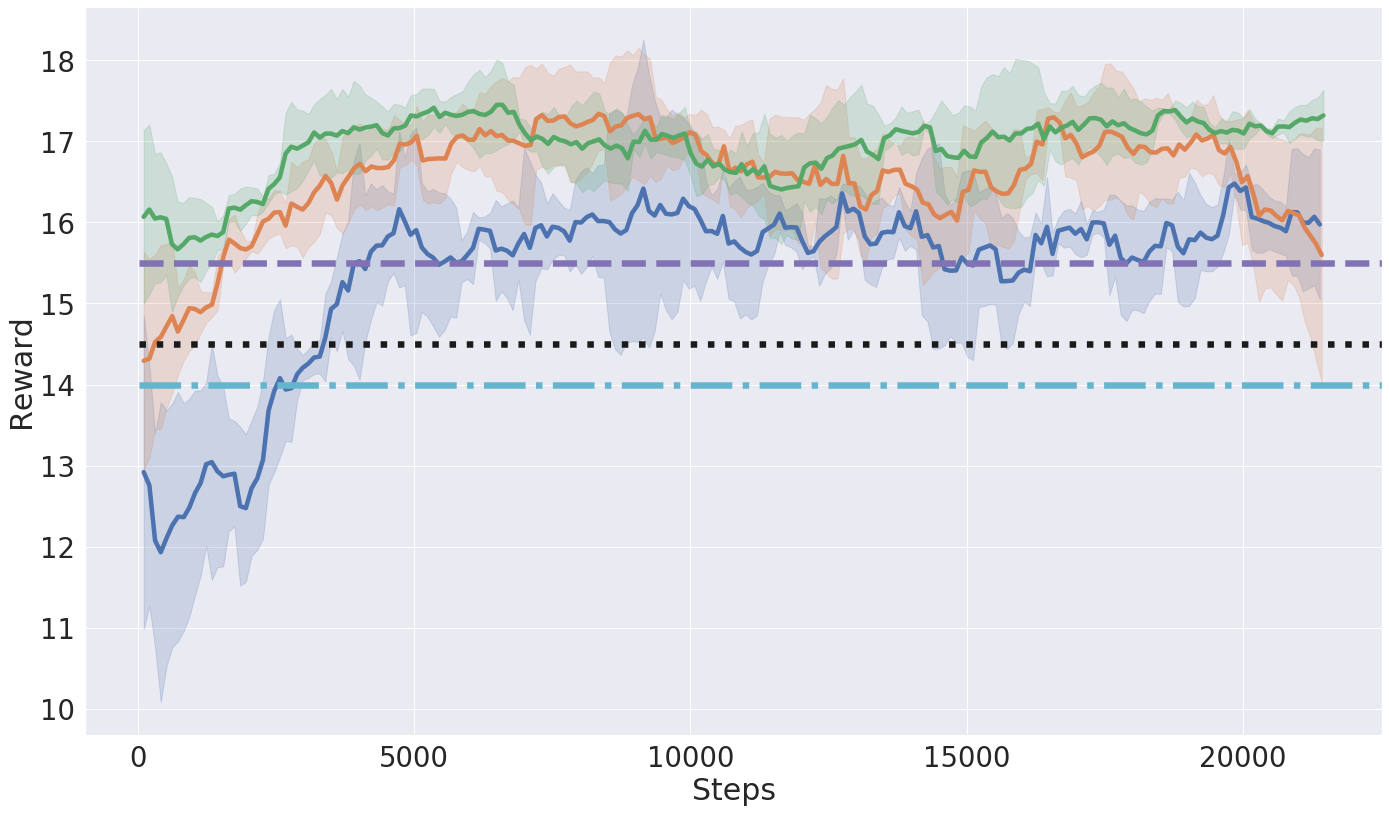

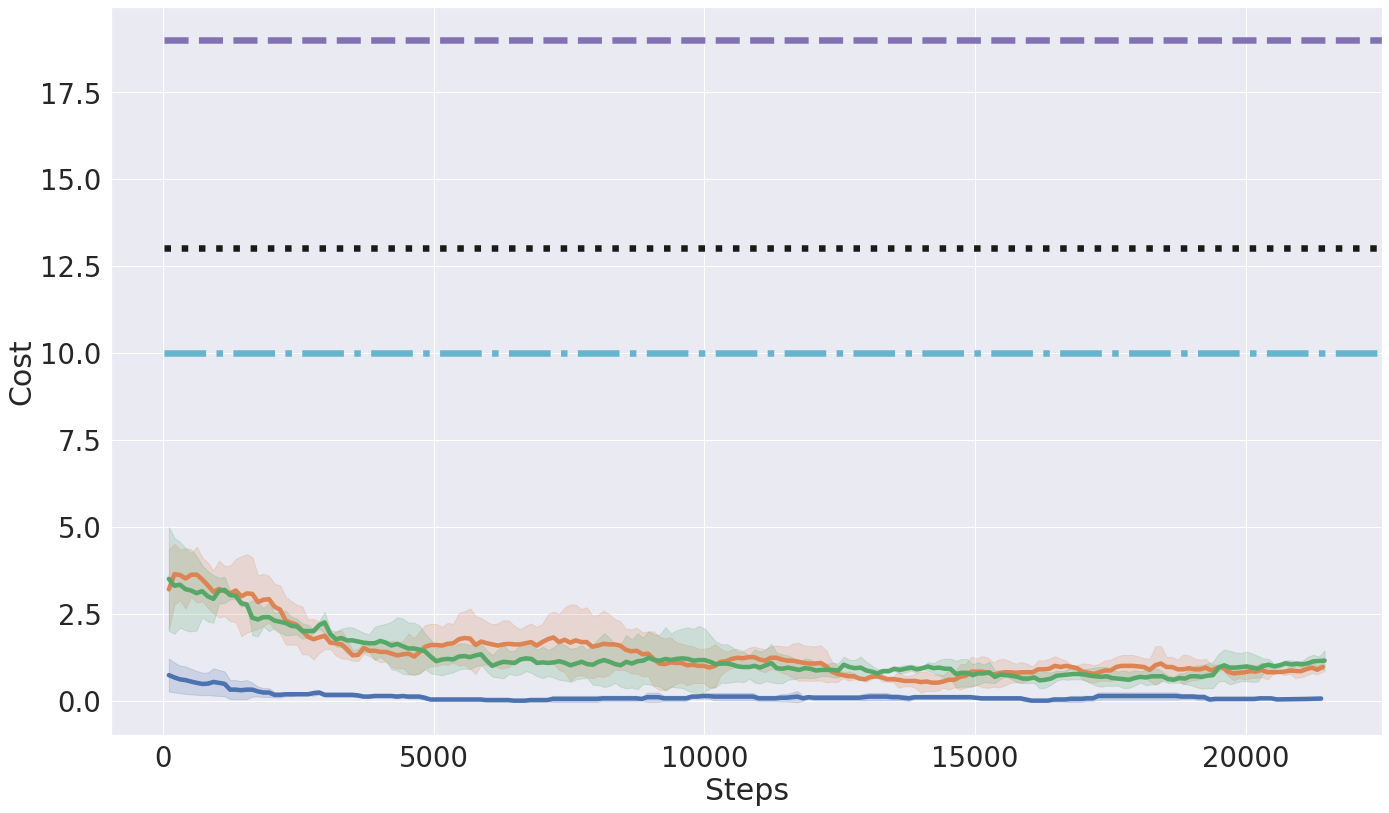

In [27]:
x_label = "Steps" # 'Episode'
y_label = 'EpRet'
condition = 'Methods'
smooth = 20
cut = 0
cut_step = 400000
env = "pg1"
logdir = ["./"+env+"/ensemble-cce","./"+env+"/ensemble-cem","./"+env+"/ensemble-random"]
#logdir = ["./pg1/ensemble-cce","./pg1/ensemble-cem","./pg1/ensemble-random"]
hline_reward = [15.5, 14, 14.5]
hline_cost = [19, 10, 13]
linename = ["TRPO", "TRPO-Lagrangian", "CPO"]

datasets = process_all_datasets(logdir)
# array of DataFrame 's
# each column is a Series
datasets = shorten_datasets(datasets, cut, condition)
for df in datasets:
    df.rename(columns={"EpCost":"Cost","EpRet":"Reward", 
                            "TotalEnvInteracts":"Steps"}, inplace=True)
new_dataset = []
for df in datasets:
    index = df.index[df["Steps"]<cut_step]
    new_dataset.append(df.iloc[index])
datasets = new_dataset

if x_label == "Steps":
    datasets = align_datasets(datasets, x_label, condition)

plot(datasets, x_label, "Reward", condition, smooth, save=env+"reward", lineloc = hline_reward, linename = linename)
plot(datasets, x_label, "Cost", condition, smooth, save=env+"cost", lineloc = hline_cost, linename = linename)

Plotting from...

./pg2/ensemble-cce
./pg2/ensemble-cem
./pg2/ensemble-random

./pg2/ensemble-cce/ensemble-cce_s0/config.yml
reading data from ./pg2/ensemble-cce/ensemble-cce_s0/progress.txt
./pg2/ensemble-cce/ensemble-cce_s10/config.yml
reading data from ./pg2/ensemble-cce/ensemble-cce_s10/progress.txt
./pg2/ensemble-cce/ensemble-cce_s100/config.yml
reading data from ./pg2/ensemble-cce/ensemble-cce_s100/progress.txt
./pg2/ensemble-cem/ensemble-cem_s0/config.yml
reading data from ./pg2/ensemble-cem/ensemble-cem_s0/progress.txt
./pg2/ensemble-cem/ensemble-cem_s100/config.yml
reading data from ./pg2/ensemble-cem/ensemble-cem_s100/progress.txt
./pg2/ensemble-cem/ensemble-cem_s10/config.yml
reading data from ./pg2/ensemble-cem/ensemble-cem_s10/progress.txt
./pg2/ensemble-random/ensemble-random_s0/config.yml
reading data from ./pg2/ensemble-random/ensemble-random_s0/progress.txt
./pg2/ensemble-random/ensemble-random_s100/config.yml
reading data from ./pg2/ensemble-random/ensemble-random_s10

/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


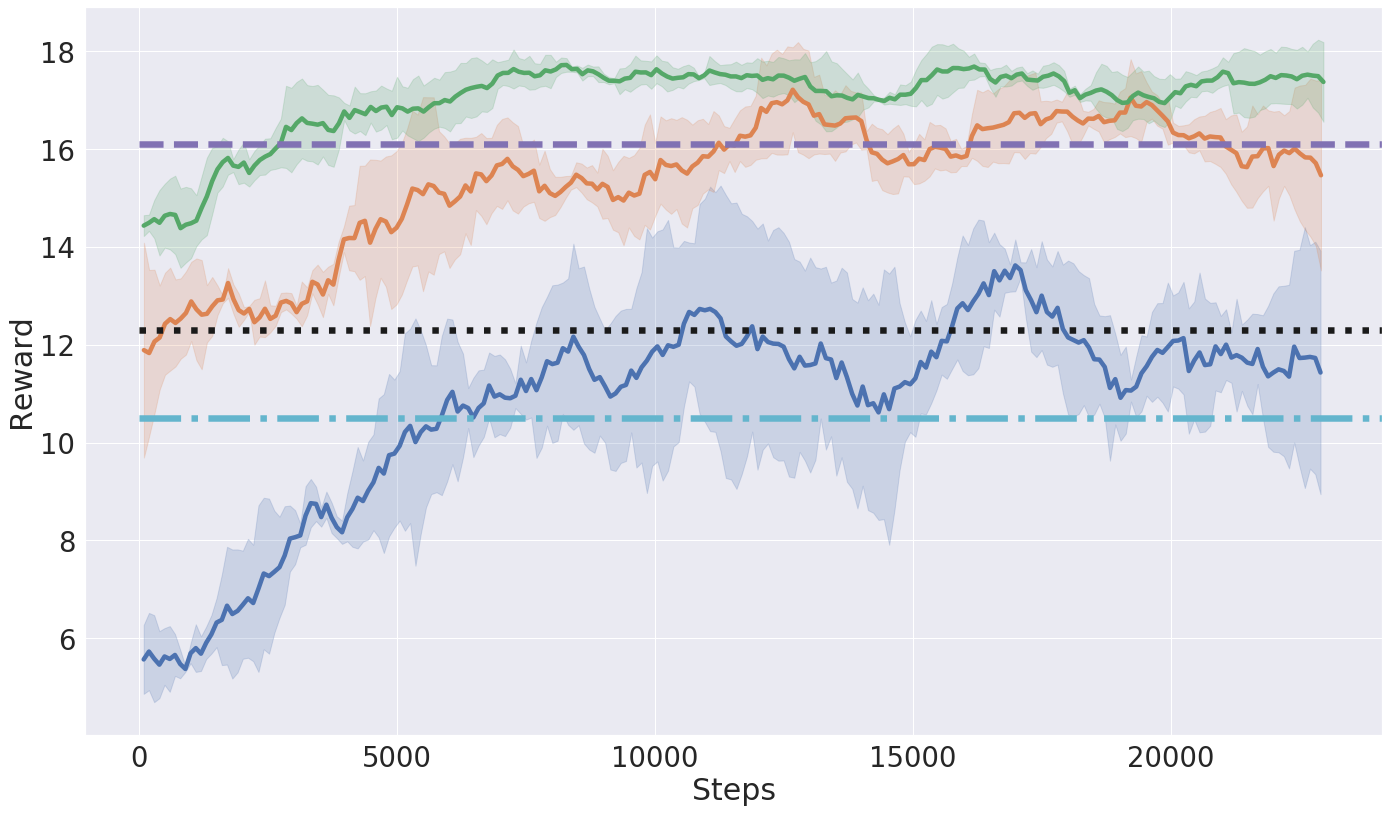

/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


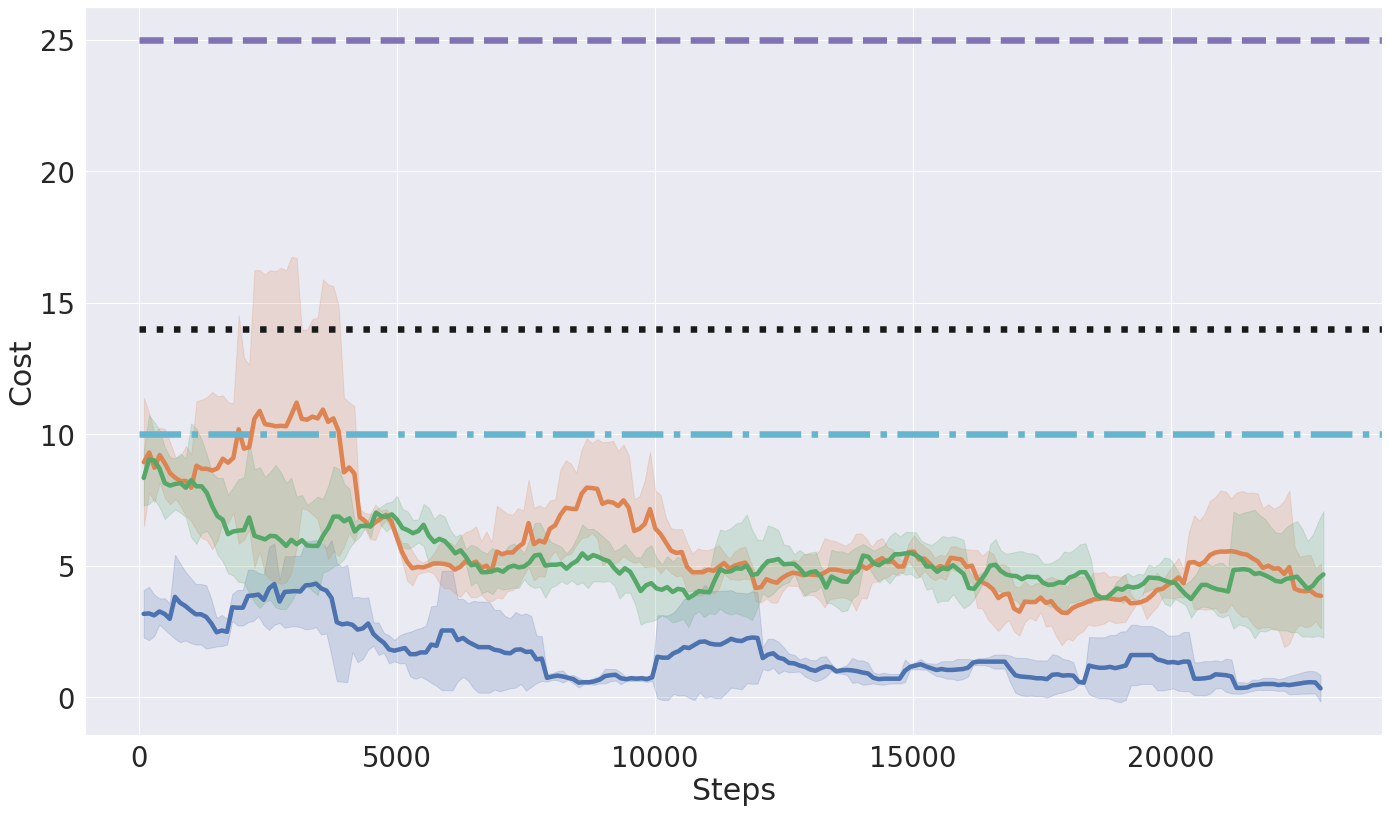

In [28]:
x_label = "Steps" # 'Episode'
y_label = 'EpRet'
condition = 'Methods'
smooth = 20
cut = 0
cut_step = 23000
env = "pg2"
logdir = ["./"+env+"/ensemble-cce","./"+env+"/ensemble-cem","./"+env+"/ensemble-random"]
#logdir = ["./pg1/ensemble-cce","./pg1/ensemble-cem","./pg1/ensemble-random"]
hline_reward = [16.1, 10.5, 12.3]
hline_cost = [25, 10, 14]
linename = ["TRPO", "TRPO-Lagrangian", "CPO"]

datasets = process_all_datasets(logdir)
# array of DataFrame 's
# each column is a Series
datasets = shorten_datasets(datasets, cut, condition)
for df in datasets:
    df.rename(columns={"EpCost":"Cost","EpRet":"Reward", 
                            "TotalEnvInteracts":"Steps"}, inplace=True)
new_dataset = []
for df in datasets:
    index = df.index[df["Steps"]<cut_step]
    new_dataset.append(df.iloc[index])
datasets = new_dataset

if x_label == "Steps":
    datasets = align_datasets(datasets, x_label, condition)

plot(datasets, x_label, "Reward", condition, smooth, save=env+"reward", lineloc = hline_reward, linename = linename)
plot(datasets, x_label, "Cost", condition, smooth, save=env+"cost", lineloc = hline_cost, linename = linename)

In [217]:
df = datasets[0]

Plotting from...

./cg1/ensemble-cce
./cg1/ensemble-cem
./cg1/ensemble-random

./cg1/ensemble-cce/ensemble-cce_s0/config.yml
reading data from ./cg1/ensemble-cce/ensemble-cce_s0/progress.txt
./cg1/ensemble-cce/ensemble-cce_s10/config.yml
reading data from ./cg1/ensemble-cce/ensemble-cce_s10/progress.txt
./cg1/ensemble-cce/ensemble-cce_s100/config.yml
reading data from ./cg1/ensemble-cce/ensemble-cce_s100/progress.txt
./cg1/ensemble-cem/ensemble-cem_s0/config.yml
reading data from ./cg1/ensemble-cem/ensemble-cem_s0/progress.txt
./cg1/ensemble-cem/ensemble-cem_s100/config.yml
reading data from ./cg1/ensemble-cem/ensemble-cem_s100/progress.txt
./cg1/ensemble-cem/ensemble-cem_s10/config.yml
reading data from ./cg1/ensemble-cem/ensemble-cem_s10/progress.txt
./cg1/ensemble-random/ensemble-random_s0/config.yml
reading data from ./cg1/ensemble-random/ensemble-random_s0/progress.txt
./cg1/ensemble-random/ensemble-random_s100/config.yml
reading data from ./cg1/ensemble-random/ensemble-random_s10

/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


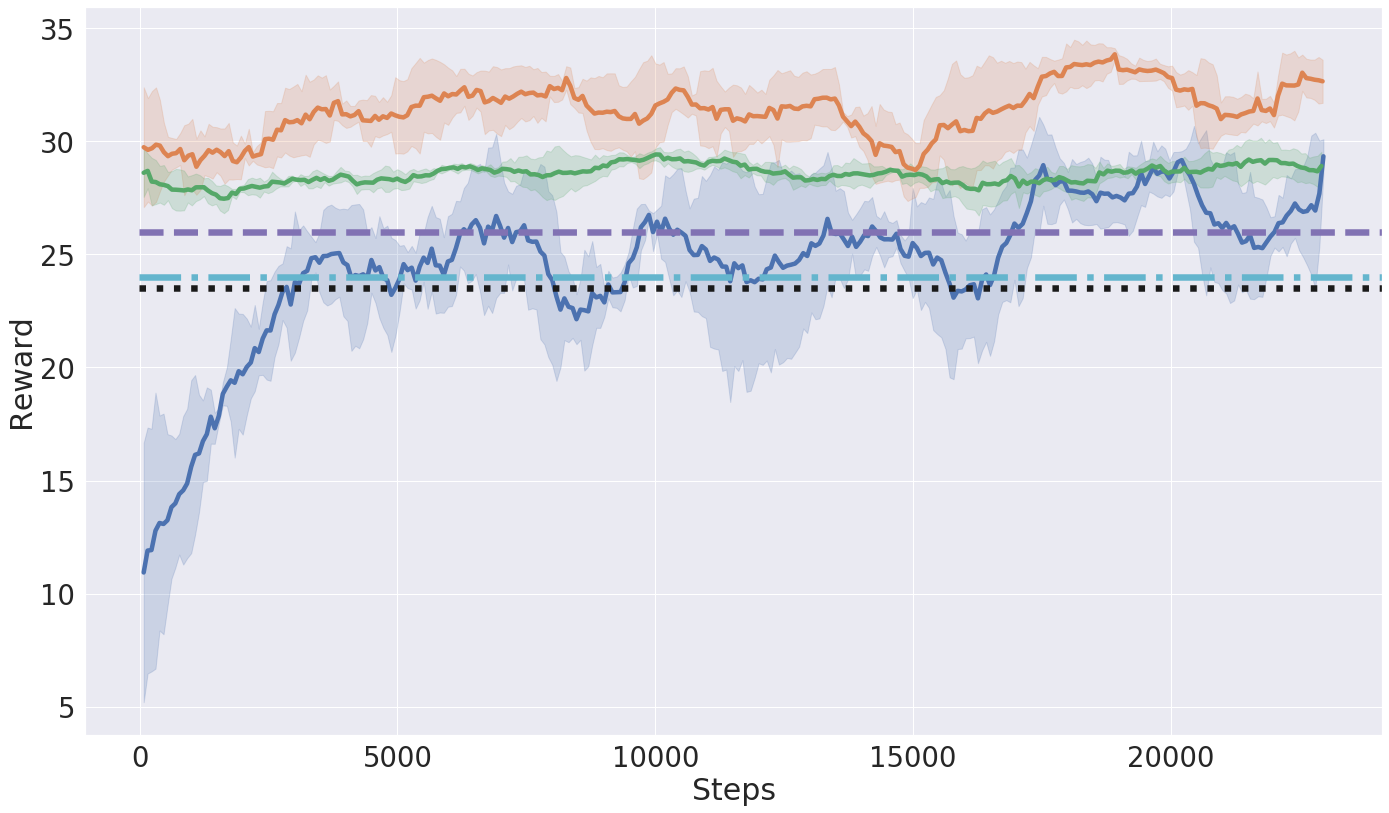

/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


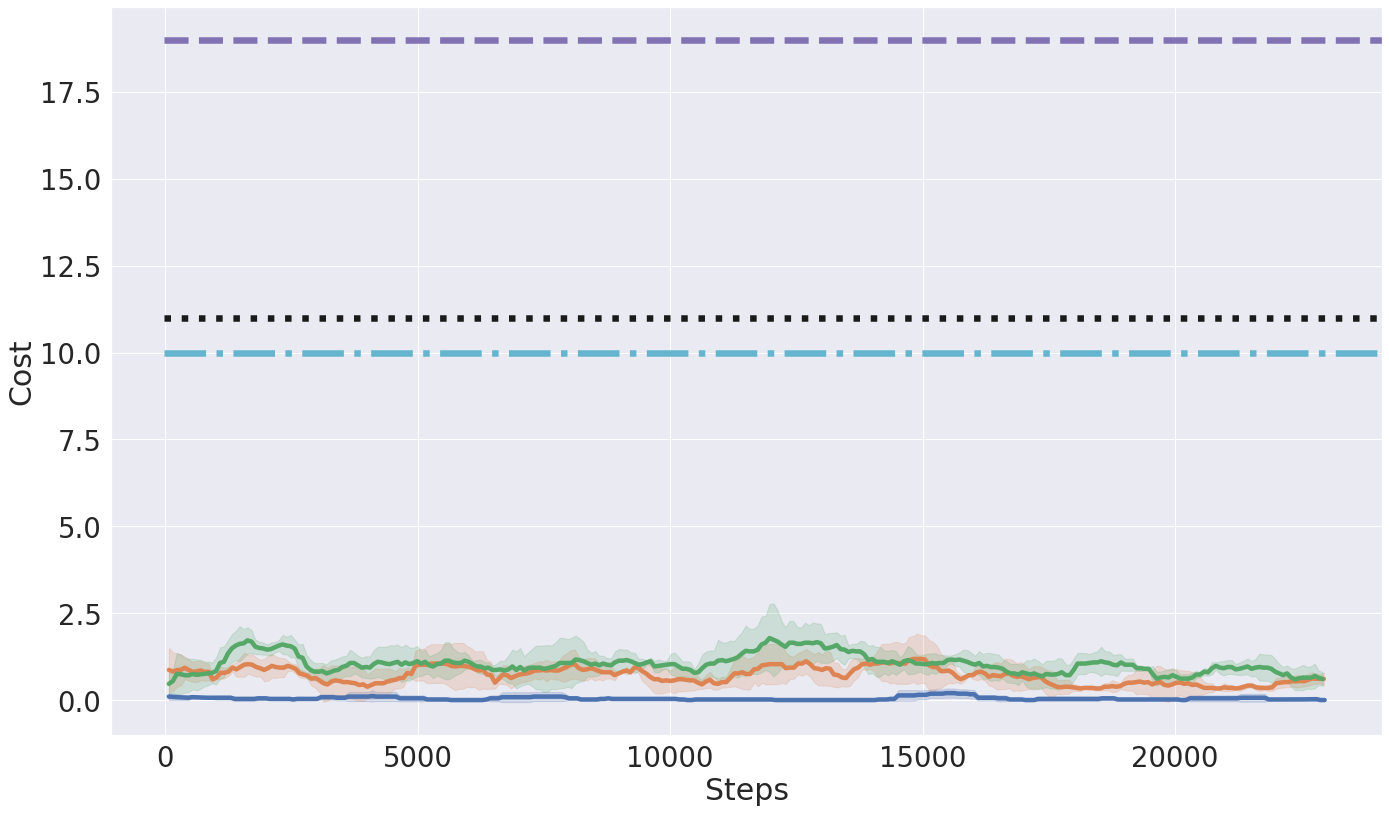

In [29]:
x_label = "Steps" # 'Episode'
y_label = 'EpRet'
condition = 'Methods'
smooth = 20
cut = 0
cut_step = 23000
env = "cg1"
logdir = ["./"+env+"/ensemble-cce","./"+env+"/ensemble-cem","./"+env+"/ensemble-random"]
#logdir = ["./pg1/ensemble-cce","./pg1/ensemble-cem","./pg1/ensemble-random"]
hline_reward = [26, 24, 23.5]
hline_cost = [19, 10, 11]
linename = ["TRPO", "TRPO-Lagrangian", "CPO"]

datasets = process_all_datasets(logdir)
# array of DataFrame 's
# each column is a Series
datasets = shorten_datasets(datasets, cut, condition)
for df in datasets:
    df.rename(columns={"EpCost":"Cost","EpRet":"Reward", 
                            "TotalEnvInteracts":"Steps"}, inplace=True)
new_dataset = []
for df in datasets:
    index = df.index[df["Steps"]<cut_step]
    new_dataset.append(df.iloc[index])
datasets = new_dataset

if x_label == "Steps":
    datasets = align_datasets(datasets, x_label, condition)

plot(datasets, x_label, "Reward", condition, smooth, save=env+"reward", lineloc = hline_reward, linename = linename)
plot(datasets, x_label, "Cost", condition, smooth, save=env+"cost", lineloc = hline_cost, linename = linename)

Plotting from...

./cg2/ensemble-cce
./cg2/ensemble-cem
./cg2/ensemble-random

./cg2/ensemble-cce/ensemble-cce_s1000/config.yml
reading data from ./cg2/ensemble-cce/ensemble-cce_s1000/progress.txt
./cg2/ensemble-cce/ensemble-cce_s0/config.yml
reading data from ./cg2/ensemble-cce/ensemble-cce_s0/progress.txt
./cg2/ensemble-cce/ensemble-cce_s1/config.yml
reading data from ./cg2/ensemble-cce/ensemble-cce_s1/progress.txt
./cg2/ensemble-cce/ensemble-cce_s10/config.yml
reading data from ./cg2/ensemble-cce/ensemble-cce_s10/progress.txt
./cg2/ensemble-cce/ensemble-cce_s100/config.yml
reading data from ./cg2/ensemble-cce/ensemble-cce_s100/progress.txt
./cg2/ensemble-cem/ensemble-cem_s0/config.yml
reading data from ./cg2/ensemble-cem/ensemble-cem_s0/progress.txt
./cg2/ensemble-cem/ensemble-cem_s100/config.yml
reading data from ./cg2/ensemble-cem/ensemble-cem_s100/progress.txt
./cg2/ensemble-cem/ensemble-cem_s10/config.yml
reading data from ./cg2/ensemble-cem/ensemble-cem_s10/progress.txt
./cg2/e

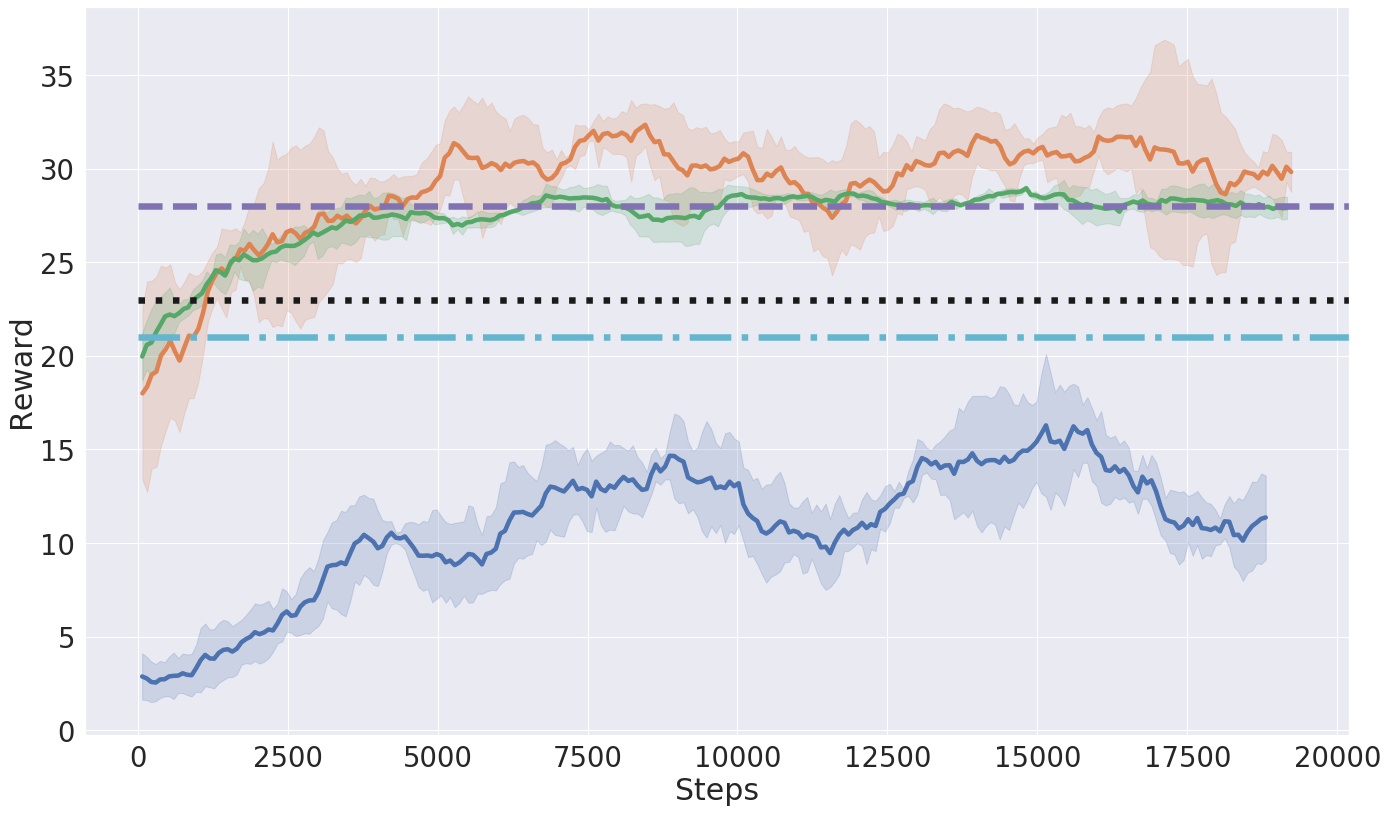

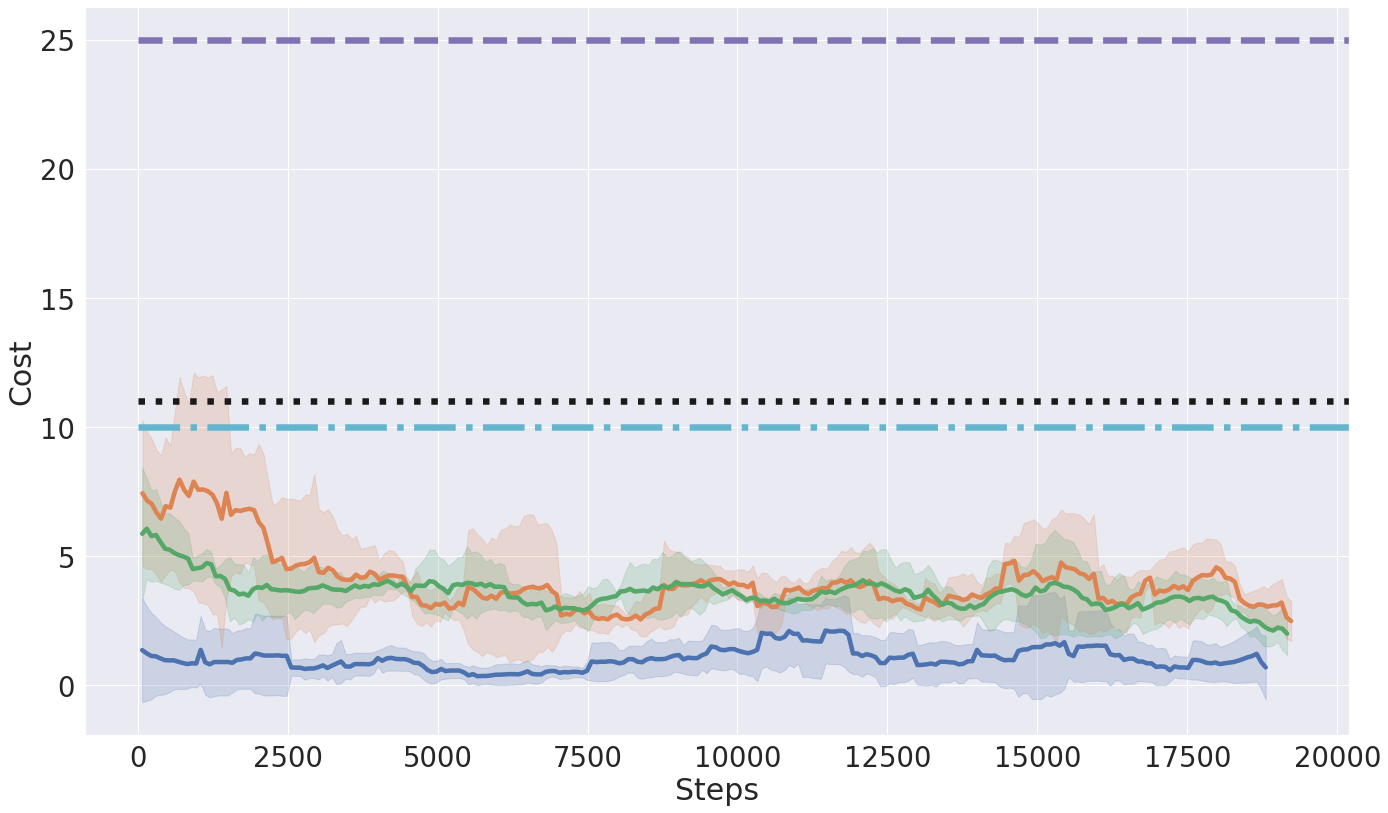

In [30]:
x_label = "Steps" # 'Episode'
y_label = 'EpRet'
condition = 'Methods'
smooth = 20
cut = 0
cut_step = 43000
env = "cg2"
logdir = ["./"+env+"/ensemble-cce","./"+env+"/ensemble-cem","./"+env+"/ensemble-random"]
#logdir = ["./pg1/ensemble-cce","./pg1/ensemble-cem","./pg1/ensemble-random"]
hline_reward = [28, 21, 23]
hline_cost = [25, 10, 11]
linename = ["TRPO", "TRPO-Lagrangian", "CPO"]

datasets = process_all_datasets(logdir)
# array of DataFrame 's
# each column is a Series
datasets = shorten_datasets(datasets, cut, condition)
for df in datasets:
    df.rename(columns={"EpCost":"Cost","EpRet":"Reward", 
                            "TotalEnvInteracts":"Steps"}, inplace=True)
new_dataset = []
for df in datasets:
    index = df.index[df["Steps"]<cut_step]
    new_dataset.append(df.iloc[index])
datasets = new_dataset

if x_label == "Steps":
    datasets = align_datasets(datasets, x_label, condition)

plot(datasets, x_label, "Reward", condition, smooth, save=env+"reward", lineloc = hline_reward, linename = linename)
plot(datasets, x_label, "Cost", condition, smooth, save=env+"cost", lineloc = hline_cost, linename = linename)

Plotting from...

./pb1/ensemble-cce/
./pb1/ensemble-cem/
./pb1/ensemble-random/

./pb1/ensemble-cce/ensemble-cce_s0/config.yml
reading data from ./pb1/ensemble-cce/ensemble-cce_s0/progress.txt
./pb1/ensemble-cce/ensemble-cce_s10/config.yml
reading data from ./pb1/ensemble-cce/ensemble-cce_s10/progress.txt
./pb1/ensemble-cce/ensemble-cce_s100/config.yml
reading data from ./pb1/ensemble-cce/ensemble-cce_s100/progress.txt
./pb1/ensemble-cem/ensemble-cem-10_s10/config.yml
reading data from ./pb1/ensemble-cem/ensemble-cem-10_s10/progress.txt
./pb1/ensemble-cem/ensemble-cem_s1/config.yml
reading data from ./pb1/ensemble-cem/ensemble-cem_s1/progress.txt
./pb1/ensemble-cem/ensemble-cem-100_s100/config.yml
reading data from ./pb1/ensemble-cem/ensemble-cem-100_s100/progress.txt
./pb1/ensemble-random/ensemble-random_s0/config.yml
reading data from ./pb1/ensemble-random/ensemble-random_s0/progress.txt
./pb1/ensemble-random/ensemble-random_s100/config.yml
reading data from ./pb1/ensemble-random/en

/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


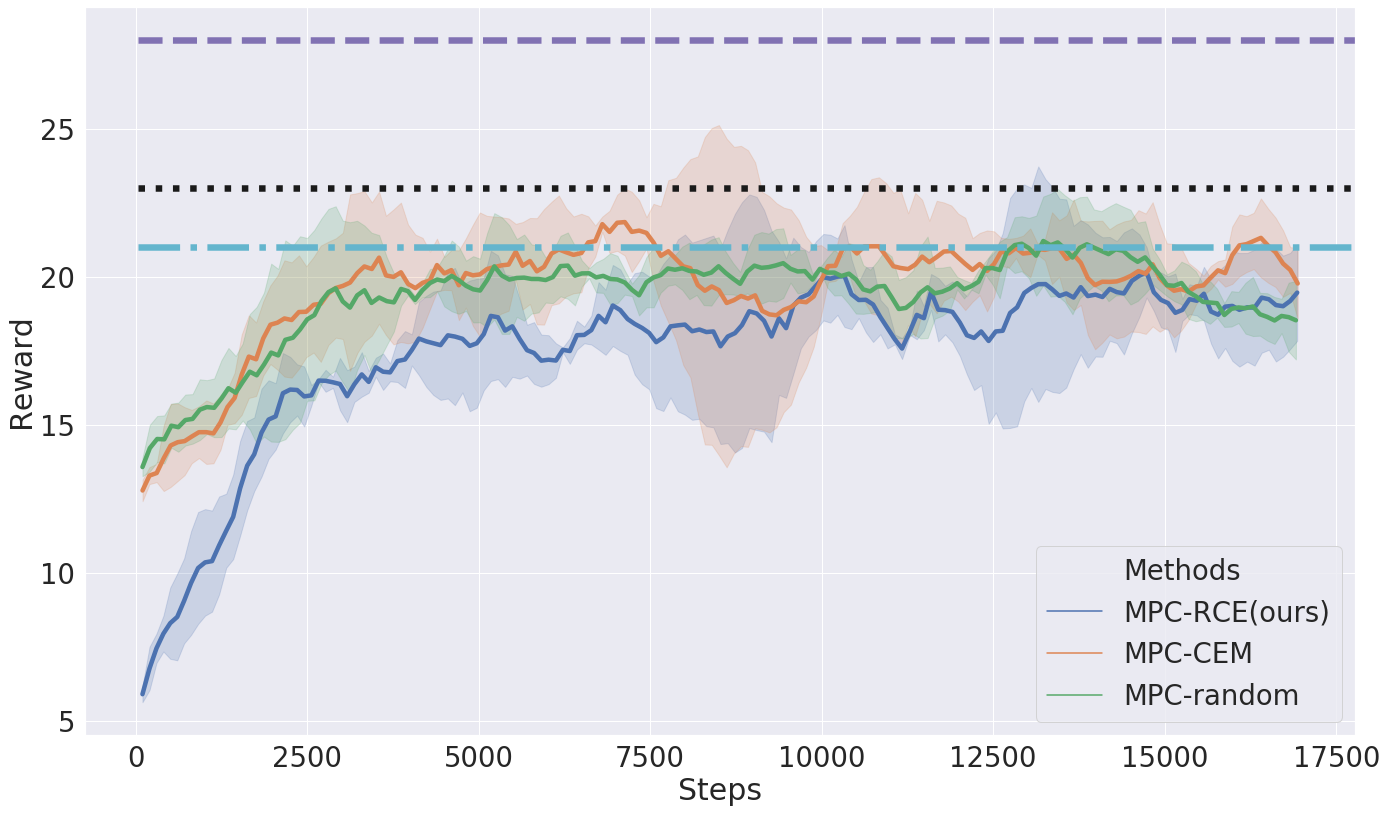

/home/zuxin/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


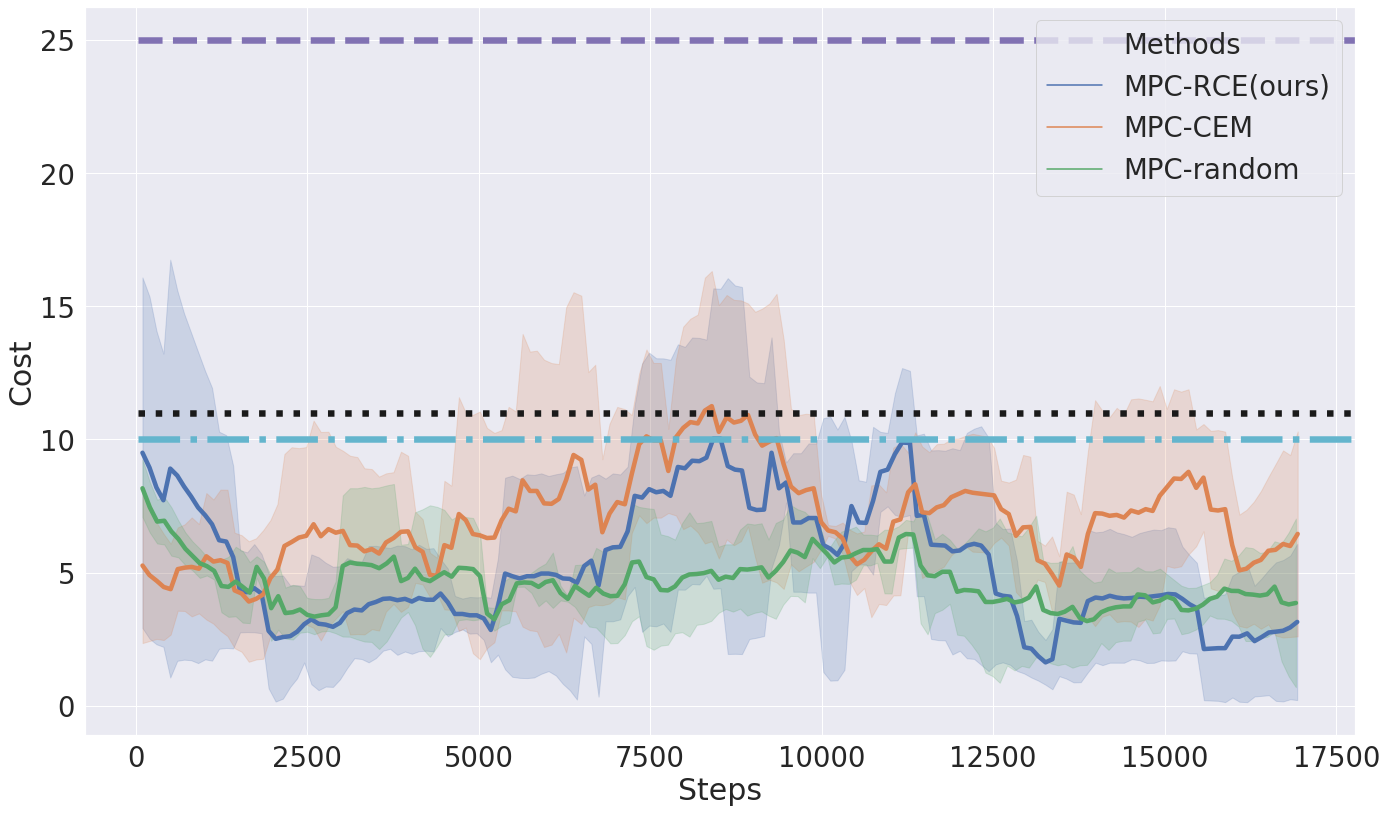

In [59]:
x_label = "Steps" # 'Episode'
y_label = 'EpRet'
condition = 'Methods'
smooth = 20
cut = 0
cut_step = 17000
env = "pb1"
logdir = ["./"+env+"/ensemble-cce/","./"+env+"/ensemble-cem/","./"+env+"/ensemble-random/"]
#logdir = ["./"+env+"/ensemble-cce-no" ,"./"+env+"/ensemble-random-no"]
#logdir = ["./"+env+"/ensemble-cce-no"]
#logdir = ["./pg1/ensemble-cce","./pg1/ensemble-cem","./pg1/ensemble-random"]
hline_reward = [28, 21, 23]
hline_cost = [25, 10, 11]
linename = ["TRPO", "TRPO-Lagrangian", "CPO"]

datasets = process_all_datasets(logdir)
# array of DataFrame 's
# each column is a Series
datasets = shorten_datasets(datasets, cut, condition)
for df in datasets:
    df.rename(columns={"EpCost":"Cost","EpRet":"Reward", 
                            "TotalEnvInteracts":"Steps"}, inplace=True)
new_dataset = []
for df in datasets:
    index = df.index[df["Steps"]<cut_step]
    new_dataset.append(df.iloc[index])
datasets = new_dataset

if x_label == "Steps":
    datasets = align_datasets(datasets, x_label, condition)

plot(datasets, x_label, "Reward", condition, smooth, save=env+"reward", lineloc = hline_reward, linename = linename)
plot(datasets, x_label, "Cost", condition, smooth, save=env+"cost", lineloc = hline_cost, linename = linename)